In [ ]:
#Install Packages
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install keras
!pip install tensorflow

In [2]:
import numpy as np
import sklearn

# === LAYER ===
class Layer():
    def __init__(self, num_inputs, num_outputs):
      self.weights = np.random.randn(num_inputs, num_outputs) * np.sqrt(2.0 / (num_inputs+num_outputs)) 
      self.biases = np.random.randn(1, num_outputs) 

    def forward(self, inputs):
      self.inputs = inputs
      self.outputs = np.dot(self.inputs, self.weights) + self.biases 

    def backward(self, del_z):
      batch_size = self.inputs.shape[0]

      self.del_w = np.dot(self.inputs.T, del_z) / batch_size
      self.del_b = np.sum(del_z, axis=0, keepdims=True) / batch_size 
      self.del_z_prev = np.dot(del_z, self.weights.T) 

# === ACTIVATION: RELU ===
class ReLU():
    def forward(self, inputs):
      self.inputs = inputs
      self.output = np.maximum(0, inputs)

    def backward(self, del_z):
      self.del_z_prev = del_z.copy()
      self.del_z_prev[self.inputs <= 0] = 0

# === ACTIVATION: SOFTMAX ===
class Softmax():
    def forward(self, inputs):
      exp_z = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
      self.output = exp_z / np.sum(exp_z, axis=1, keepdims=True) 

# === LOSS: CROSS-ENTROPY ===
class CategoricalCrossentropy:
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        if len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        else:
            correct_confidences = y_pred_clipped[range(len(y_pred_clipped)), y_true]
        return -np.mean(np.log(correct_confidences))

# === COMBINED SOFTMAX + CROSS-ENTROPY BACKWARD ===
class Softmax_CategoricalCrossentropy:
    def backward(self, y_pred, y_true):
        samples = len(y_pred)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.del_z_prev = y_pred.copy()
        self.del_z_prev[range(samples), y_true] -= 1 
        self.del_z_prev = self.del_z_prev / samples

# === OPTIMIZER: SGD ===
class SGD:
    def __init__(self, learning_rate=0.01):
        self.lr = learning_rate

    def update_params(self, layer):
        layer.weights -= self.lr * layer.del_w
        layer.biases  -= self.lr * layer.del_b

In [3]:
# === MLP ===
# Allow for flexible number of hidden layers
class MLP:
    def __init__(self, layers:list, optimizer=None):
      self.layer_count = len(layers)
      self.hidden_layers = self.layer_count - 1
      self.layers = [Layer(layers[i], layers[i+1]) for i in range(self.hidden_layers)]
      self.activations = [ReLU() for _ in range(self.hidden_layers - 1)] + [Softmax()]
      self.loss = CategoricalCrossentropy()
      self.loss_activation = Softmax_CategoricalCrossentropy() 
      self.optimizer = optimizer

    # Forward Propagation
    def forward(self, x):
      current = x
      for layer, activation in zip(self.layers, self.activations):
        layer.forward(current)              
        activation.forward(layer.outputs)   
        current = activation.output         
      return current

    # Backward Propagation
    def backward(self, y_true):
        self.loss_activation.backward(self.activations[-1].output, y_true)
        grad_from_next_layer = self.loss_activation.del_z_prev 
        self.layers[-1].backward(grad_from_next_layer)
        grad_from_next_layer = self.layers[-1].del_z_prev 

        self.optimizer.update_params(self.layers[-1])

        for i in reversed(range(len(self.layers) - 1)):
            current_activation = self.activations[i]  
            current_layer = self.layers[i]            
            current_activation.backward(grad_from_next_layer)
            grad_to_layer_backward = current_activation.del_z_prev 
            current_layer.backward(grad_to_layer_backward)
            grad_from_next_layer = current_layer.del_z_prev
        
        for layer in self.layers:
            self.optimizer.update_params(layer)
             

    def fit(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=64):
        
        # Data preparation (normalization)
        X_train = X_train / 255.0
        X_test = X_test / 255.0
        
        # One-hot encode the labels
        y_train_one_hot = np.zeros((y_train.size, y_train.max() + 1))
        y_train_one_hot[np.arange(y_train.size), y_train] = 1
        
        y_test_one_hot = np.zeros((y_test.size, y_test.max() + 1))
        y_test_one_hot[np.arange(y_test.size), y_test] = 1

        num_samples = len(X_train)

        for epoch in range(epochs):
            
            indices = np.arange(num_samples)
            np.random.shuffle(indices)            
            epoch_loss = 0
            
            # Mini-batch loop
            for i in range(0, num_samples, batch_size):
                batch_indices = indices[i:i + batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train_one_hot[batch_indices]

                y_pred = self.forward(X_batch)
                
                # Backward pass
                self.backward(y_batch)
                
                # Calculate and accumulate loss
                loss = self.loss.forward(y_pred, y_batch)
                epoch_loss += loss
            
            # Calculate metrics
            avg_loss = epoch_loss / (len(X_train) / batch_size)
            
            # Training accuracy
            y_pred_train = self.forward(X_train)
            y_pred_train_labels = np.argmax(y_pred_train, axis=1)
            train_accuracy = np.mean(y_pred_train_labels == y_train)   

            # Validation accuracy
            y_pred_test = self.forward(X_test)
            y_pred_test_labels = np.argmax(y_pred_test, axis=1)
            val_accuracy = np.mean(y_pred_test_labels == y_test)

            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")    


In [4]:
# === DATA PREPARATION (FASHION MNIST)===

from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# Load the dataset
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Flatten the images and normalize pixel values (moved into fit function)
X_train_full = X_train_full.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Split a validation set from the training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

print(f"Training data shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, labels shape: {y_test.shape}")

Training data shape: (54000, 784), labels shape: (54000,)
Validation data shape: (6000, 784), labels shape: (6000,)
Test data shape: (10000, 784), labels shape: (10000,)


In [5]:
# Using a ready-made Adam Optimiser function (to compare with Mini batch SGD):
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m_w, self.v_w = {}, {}
        self.m_b, self.v_b = {}, {}
        self.t = 0

    def update_params(self, layer):
        if layer not in self.m_w:
            self.m_w[layer] = np.zeros_like(layer.weights)
            self.v_w[layer] = np.zeros_like(layer.weights)
            self.m_b[layer] = np.zeros_like(layer.biases)
            self.v_b[layer] = np.zeros_like(layer.biases)

        self.t += 1

        # === Weights update ===
        self.m_w[layer] = self.beta1 * self.m_w[layer] + (1 - self.beta1) * layer.del_w
        self.v_w[layer] = self.beta2 * self.v_w[layer] + (1 - self.beta2) * (layer.del_w ** 2)

        m_hat_w = self.m_w[layer] / (1 - self.beta1 ** self.t)
        v_hat_w = self.v_w[layer] / (1 - self.beta2 ** self.t)

        layer.weights -= self.lr * m_hat_w / (np.sqrt(v_hat_w) + self.eps)

        # === Biases update ===
        self.m_b[layer] = self.beta1 * self.m_b[layer] + (1 - self.beta1) * layer.del_b
        self.v_b[layer] = self.beta2 * self.v_b[layer] + (1 - self.beta2) * (layer.del_b ** 2)

        m_hat_b = self.m_b[layer] / (1 - self.beta1 ** self.t)
        v_hat_b = self.v_b[layer] / (1 - self.beta2 ** self.t)

        layer.biases -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.eps)

print("Training ANN using Adam Optimiser on Fashion MNIST")
model_fm = MLP([784, 128, 64, 10], optimizer=Adam(lr=0.001))
model_fm.fit(X_train, y_train, X_val, y_val, epochs=100, batch_size=128)

Training ANN using Adam Optimiser on Fashion MNIST
Epoch 1/100 | Loss: 0.5709 | Train Acc: 0.8510 | Val Acc: 0.8462
Epoch 2/100 | Loss: 0.3840 | Train Acc: 0.8669 | Val Acc: 0.8563
Epoch 3/100 | Loss: 0.3429 | Train Acc: 0.8862 | Val Acc: 0.8765
Epoch 4/100 | Loss: 0.3181 | Train Acc: 0.8918 | Val Acc: 0.8847
Epoch 5/100 | Loss: 0.3019 | Train Acc: 0.8957 | Val Acc: 0.8832
Epoch 6/100 | Loss: 0.2839 | Train Acc: 0.9026 | Val Acc: 0.8858
Epoch 7/100 | Loss: 0.2724 | Train Acc: 0.9055 | Val Acc: 0.8883
Epoch 8/100 | Loss: 0.2596 | Train Acc: 0.9100 | Val Acc: 0.8910
Epoch 9/100 | Loss: 0.2503 | Train Acc: 0.9122 | Val Acc: 0.8892
Epoch 10/100 | Loss: 0.2412 | Train Acc: 0.9210 | Val Acc: 0.8950
Epoch 11/100 | Loss: 0.2347 | Train Acc: 0.9187 | Val Acc: 0.8940
Epoch 12/100 | Loss: 0.2247 | Train Acc: 0.9187 | Val Acc: 0.8915
Epoch 13/100 | Loss: 0.2180 | Train Acc: 0.9236 | Val Acc: 0.8943
Epoch 14/100 | Loss: 0.2099 | Train Acc: 0.9222 | Val Acc: 0.8872
Epoch 15/100 | Loss: 0.2098 | Trai

In [9]:
# --- Test the trained model using scikit-learn's metric ---

print("Evaluating model on test data.: ")
# Import the necessary function
from sklearn.metrics import accuracy_score
y_pred_test= model_fm.forward(X_test / 255.0)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Calculate final test accuracy using sklearn
test_accuracy = accuracy_score(y_test, y_pred_test_labels)

print(f"Final Test Accuracy (with Adam): {test_accuracy:.4f}")

Evaluating model on test data.: 
Final Test Accuracy (with Adam): 0.8817


Final Test Accuracy: 88.17
Number of misclassified samples: 1183


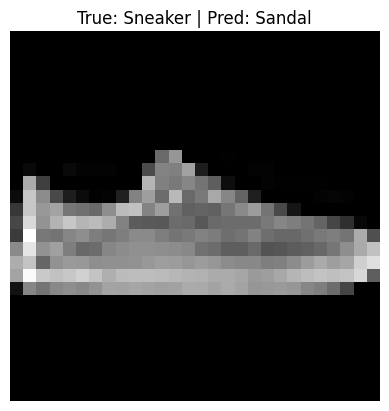

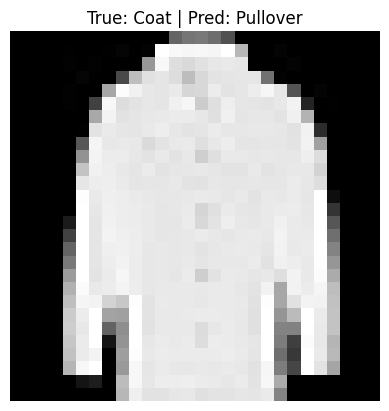

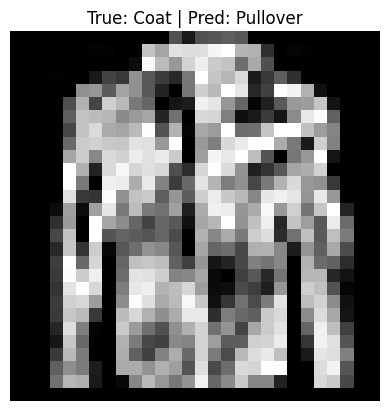

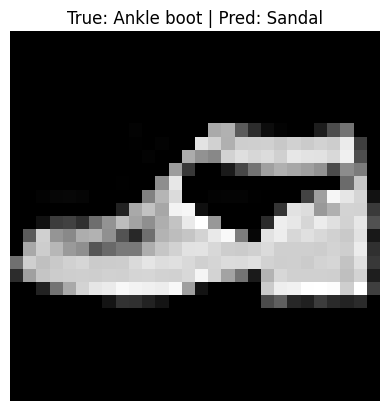

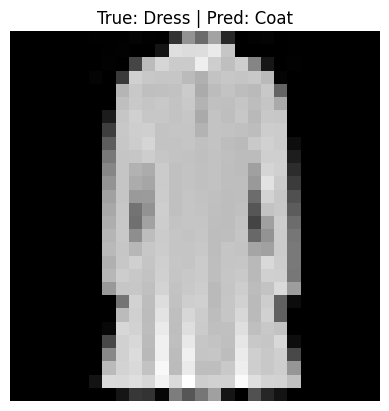

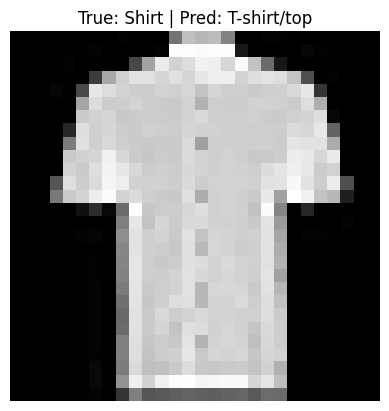

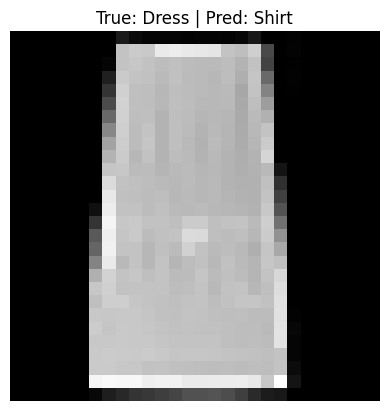

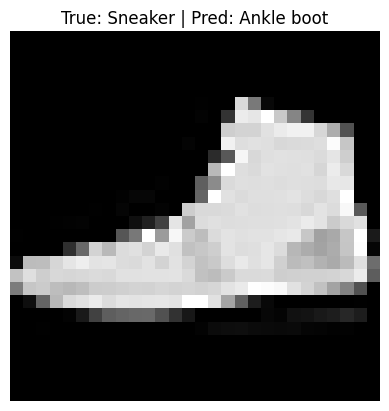

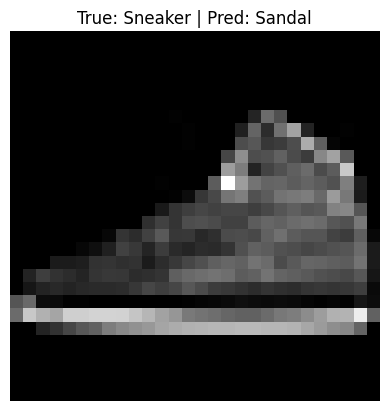

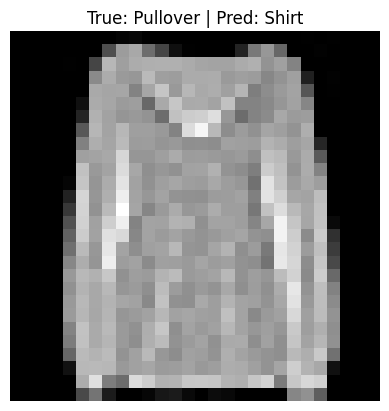

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

fashion_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# --- Test the trained model ---
X_test_norm = X_test / 255.0
y_pred_test = model_fm.forward(X_test_norm)
y_pred_labels = np.argmax(y_pred_test, axis=1)

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Final Test Accuracy: {test_accuracy*100}")

# --- Find misclassified samples ---
misclassified_idx = np.where(y_pred_labels != y_test)[0]
print(f"Number of misclassified samples: {len(misclassified_idx)}")

# Print a few examples
num_examples = 10
for i in misclassified_idx[:num_examples]:
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    true_name = fashion_labels[y_test[i]]
    pred_name = fashion_labels[y_pred_labels[i]]
    plt.title(f"True: {true_name} | Pred: {pred_name}")
    plt.axis('off')
    plt.show()


In [13]:
print("Training ANN with Mini batch GD on Fashion Mnist")
mlp_fm = MLP([784, 128, 64, 10], optimizer=SGD(learning_rate=0.01))
mlp_fm.fit(X_train, y_train, X_val, y_val, epochs=100, batch_size=128)

Training ANN with Mini batch GD on Fashion Mnist
Epoch 1/100 | Loss: 2.5289 | Train Acc: 0.1227 | Val Acc: 0.1195
Epoch 2/100 | Loss: 2.3237 | Train Acc: 0.1901 | Val Acc: 0.1887
Epoch 3/100 | Loss: 2.2141 | Train Acc: 0.2585 | Val Acc: 0.2560
Epoch 4/100 | Loss: 2.1386 | Train Acc: 0.3291 | Val Acc: 0.3240
Epoch 5/100 | Loss: 2.0796 | Train Acc: 0.3787 | Val Acc: 0.3777
Epoch 6/100 | Loss: 2.0280 | Train Acc: 0.4144 | Val Acc: 0.4128
Epoch 7/100 | Loss: 1.9794 | Train Acc: 0.4441 | Val Acc: 0.4423
Epoch 8/100 | Loss: 1.9323 | Train Acc: 0.4709 | Val Acc: 0.4693
Epoch 9/100 | Loss: 1.8867 | Train Acc: 0.4922 | Val Acc: 0.4923
Epoch 10/100 | Loss: 1.8428 | Train Acc: 0.5107 | Val Acc: 0.5097
Epoch 11/100 | Loss: 1.8006 | Train Acc: 0.5251 | Val Acc: 0.5282
Epoch 12/100 | Loss: 1.7599 | Train Acc: 0.5379 | Val Acc: 0.5392
Epoch 13/100 | Loss: 1.7208 | Train Acc: 0.5499 | Val Acc: 0.5522
Epoch 14/100 | Loss: 1.6831 | Train Acc: 0.5591 | Val Acc: 0.5613
Epoch 15/100 | Loss: 1.6467 | Train 

In [15]:
# === DATA PREPARATION (MNIST) ===

from keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Load the dataset
(X_train_full1, y_train_full1), (X_test1, y_test1) = mnist.load_data()

# Flatten the images and normalize pixel values (moved into fit function)
# Images are 28x28, so each input sample has 784 features
X_train_full1 = X_train_full1.reshape(-1, 28*28)
X_test1 = X_test1.reshape(-1, 28*28)

# Split a validation set from the training data
X_train1, X_val1, y_train1, y_val1 = train_test_split(
    X_train_full1, y_train_full1, test_size=0.1, random_state=42
)

print(f"Training data shape: {X_train1.shape}, labels shape: {y_train1.shape}")
print(f"Validation data shape: {X_val1.shape}, labels shape: {y_val1.shape}")
print(f"Test data shape: {X_test1.shape}, labels shape: {y_test1.shape}")

Training data shape: (54000, 784), labels shape: (54000,)
Validation data shape: (6000, 784), labels shape: (6000,)
Test data shape: (10000, 784), labels shape: (10000,)


In [16]:
model_mnist = MLP([784, 128, 64, 10], optimizer=Adam(lr=0.001))
model_mnist.fit(X_train1, y_train1, X_val1, y_val1, epochs=100, batch_size=128)

Epoch 1/100 | Loss: 0.3923 | Train Acc: 0.9521 | Val Acc: 0.9493
Epoch 2/100 | Loss: 0.1353 | Train Acc: 0.9714 | Val Acc: 0.9647
Epoch 3/100 | Loss: 0.0910 | Train Acc: 0.9806 | Val Acc: 0.9718
Epoch 4/100 | Loss: 0.0680 | Train Acc: 0.9845 | Val Acc: 0.9733
Epoch 5/100 | Loss: 0.0543 | Train Acc: 0.9881 | Val Acc: 0.9772
Epoch 6/100 | Loss: 0.0441 | Train Acc: 0.9860 | Val Acc: 0.9737
Epoch 7/100 | Loss: 0.0363 | Train Acc: 0.9920 | Val Acc: 0.9772
Epoch 8/100 | Loss: 0.0293 | Train Acc: 0.9940 | Val Acc: 0.9763
Epoch 9/100 | Loss: 0.0239 | Train Acc: 0.9949 | Val Acc: 0.9772
Epoch 10/100 | Loss: 0.0197 | Train Acc: 0.9960 | Val Acc: 0.9788
Epoch 11/100 | Loss: 0.0179 | Train Acc: 0.9947 | Val Acc: 0.9775
Epoch 12/100 | Loss: 0.0152 | Train Acc: 0.9965 | Val Acc: 0.9782
Epoch 13/100 | Loss: 0.0123 | Train Acc: 0.9959 | Val Acc: 0.9770
Epoch 14/100 | Loss: 0.0110 | Train Acc: 0.9973 | Val Acc: 0.9795
Epoch 15/100 | Loss: 0.0076 | Train Acc: 0.9984 | Val Acc: 0.9812
Epoch 16/100 | Loss

Final Test Accuracy: 0.9811
Number of misclassified samples: 189


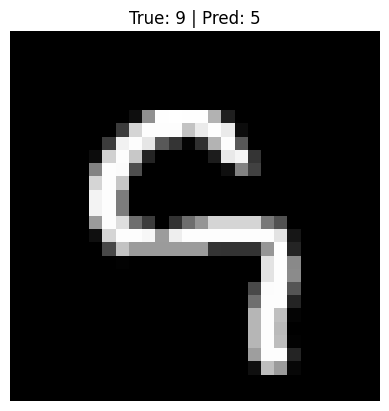

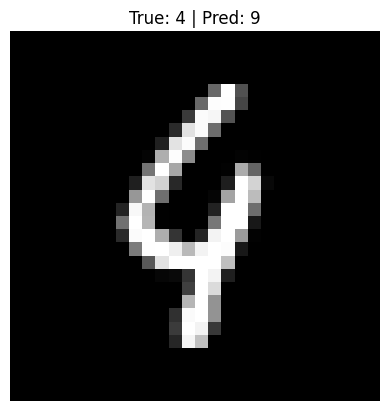

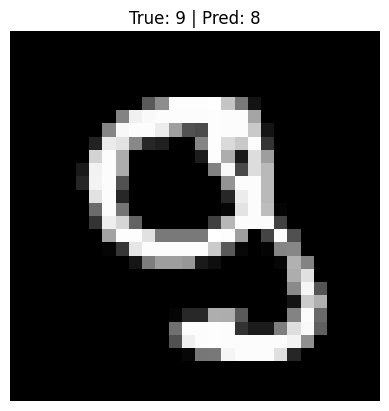

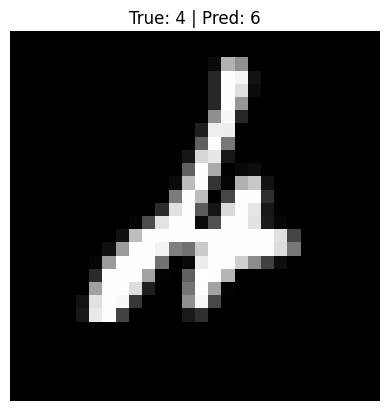

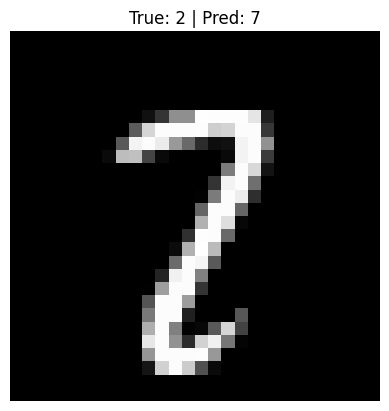

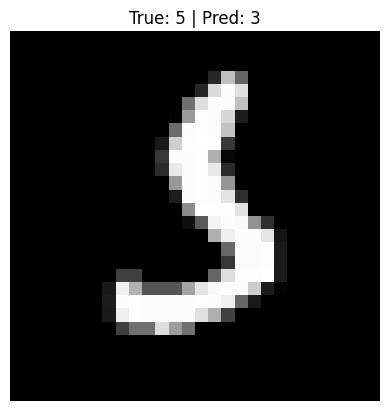

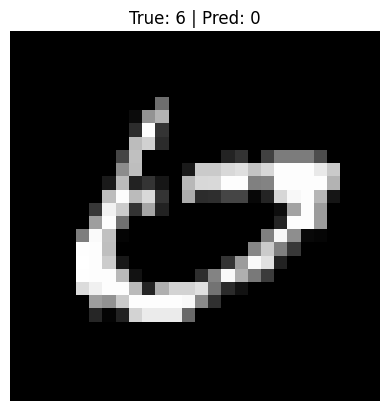

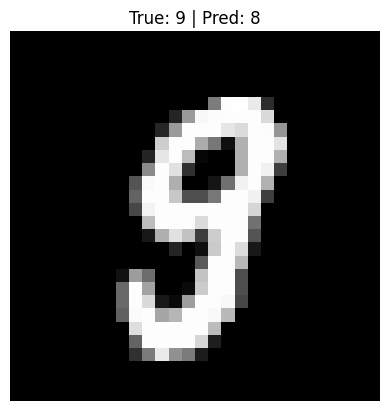

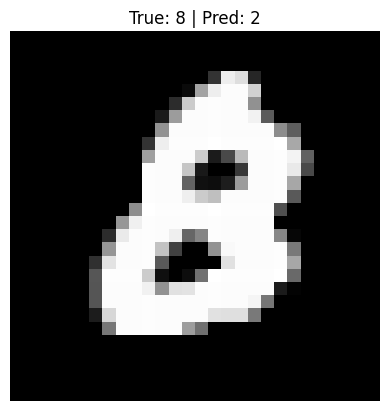

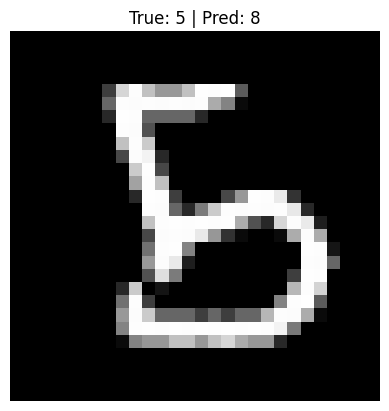

In [20]:
# Normalize test data
X_test_norm1 = X_test1.reshape(-1, 28*28) / 255.0

# Forward pass
y_pred_test1 = model_mnist.forward(X_test_norm1)
y_pred_labels1 = np.argmax(y_pred_test1, axis=1)

# Ensure test labels are integers
y_test_labels1 = y_test1

# Accuracy
from sklearn.metrics import accuracy_score
test_accuracy1 = accuracy_score(y_test_labels1, y_pred_labels1)
print(f"Final Test Accuracy: {test_accuracy1:.4f}")

# --- Find misclassified samples ---
misclassified_idx1 = np.where(y_pred_labels1 != y_test1)[0]
print(f"Number of misclassified samples: {len(misclassified_idx1)}")

# Print a few examples
num_examples1 = 10
for i in misclassified_idx1[:num_examples1]:
    plt.imshow(X_test1[i].reshape(28, 28), cmap='gray')
    true_name = y_test1[i]
    pred_name = y_pred_labels1[i]
    plt.title(f"True: {true_name} | Pred: {pred_name}")
    plt.axis('off')
    plt.show()
